In [1]:
import colorsys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Read in raw qPCR data.

In [3]:
qPCR_df = pd.read_csv('20240111_intensities.csv')
qPCR_df = qPCR_df.loc[:, 'A1':'H12']
sample_df = pd.read_csv('samples.csv')

Subtract the baseline from each sample (average of first 3 readings). Use median because first 5 cycles are very noisy for some samples with some large outliers.

In [4]:
qPCR_df = qPCR_df.sub(qPCR_df.iloc[:3].mean())

Merge sample info with qPCR data.

In [5]:
# Transpose to have wells as rows
qPCR_df = qPCR_df.transpose()

# Reset the index to make the well names a column
qPCR_df.reset_index(inplace=True)
qPCR_df = qPCR_df.rename(columns={'index': 'well'})

# Merge the sample information with the qPCR data and make long
merged_df = pd.merge(qPCR_df, sample_df, on='well', how='inner')
long_df = pd.melt(merged_df, id_vars=['sample', 'replicate', 'qPCR_replicate', 'well'],
                         var_name='cycle', value_name='fluorescence')
# Make cycles 1-indexed
long_df['cycle'] = long_df['cycle'] + 1
df = long_df[['sample', 'replicate', 'qPCR_replicate', 'cycle', 'fluorescence']]

df['sample_ID'] = df['sample'] + '_' + df['qPCR_replicate'].astype(str)

df.head()

,sample,replicate,qPCR_replicate,cycle,fluorescence,sample_ID
0,input_0.5,1,1,1,7.950121,input_0.5_1
1,input_0.5,2,1,1,3.699920,input_0.5_1
2,assembled_0.5,1,1,1,-1.496420,assembled_0.5_1
3,assembled_0.5,2,1,1,2.009382,assembled_0.5_1
4,input_0.25,1,1,1,1.139116,input_0.25_1


In [6]:
def generate_color_gradient(start_color, num_shades):
    '''Generate a palette of hex colours in increasingly lighter
    shades from an initial starting colour.
    '''

    start_rgb = tuple(int(start_color[i:i + 2], 16) / 255 for i in (1, 3, 5))
    h, l, s = colorsys.rgb_to_hls(*start_rgb)
    
    gradient_colors = []
    for i in range(num_shades):
        lightness = l + (1.0 - l) * (i / (num_shades))
        new_rgb = colorsys.hls_to_rgb(h, lightness, s)
        new_rgb = [i * 255 for i in new_rgb]
        new_hex = "#{:02X}{:02X}{:02X}".format(int(new_rgb[0]), int(new_rgb[1]), int(new_rgb[2]))
        gradient_colors.append(new_hex)
    
    return gradient_colors

In [7]:
palette = {}
samples = df['sample'].unique()
reps = df['qPCR_replicate'].unique()
colours = iter(sns.color_palette("tab10").as_hex())
for sample in samples:
    colour = next(colours)
    grad_colours = generate_color_gradient(colour, len(reps))
    for rep, colour in zip(reps, grad_colours):
        palette[sample + '_' + str(rep)] = colour

(-10.0, 150.0)

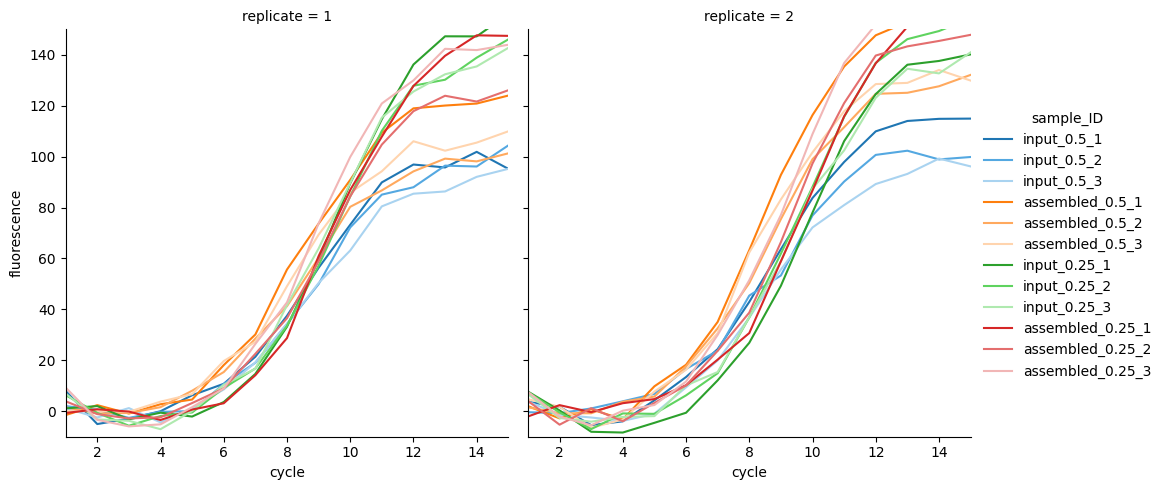

In [12]:
sns.relplot(
    data=df,
    x="cycle", y="fluorescence",
    col="replicate", hue="sample_ID",
    palette=palette, kind="line",
    col_wrap=2, hue_order=palette.keys(),
)
plt.xlim(1, 15)
plt.ylim(-10, 150)